In [1]:
# Set dates of baseline and follow-up periods
d4 = '2019-03-01' # month after end of follow-up period
d3 = '2018-09-01' # follow-up start
d2 = '2018-03-01' # month after end of baseline period
d1 = '2017-09-01' # baseline start


# Import dataset from BigQuery
import pandas as pd
import numpy as np
from ebmdatalab import bq

q = '''SELECT *, DATE_DIFF(month,'2017-08-01', MONTH) AS month_no FROM ebmdatalab.measures.practice_data_ktt9_cephalosporins
WHERE EXTRACT (YEAR from month)  >= 2017
'''
df1 = bq.cached_read(q, csv_path='data/ktt9_cephalosporins_data.csv')
df1["month"] = pd.to_datetime(df1.month)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287140 entries, 0 to 287139
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   numerator         287140 non-null  int64         
 1   denominator       287140 non-null  int64         
 2   practice_id       287140 non-null  object        
 3   pcn_id            236460 non-null  object        
 4   pct_id            287140 non-null  object        
 5   stp_id            285740 non-null  object        
 6   regional_team_id  285740 non-null  object        
 7   month             287140 non-null  datetime64[ns]
 8   calc_value        251171 non-null  float64       
 9   percentile        251171 non-null  float64       
 10  month_no          287140 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 24.1+ MB


### Restrict data to baseline and follow-up periods

In [2]:
import datetime

conditions = [
    (df1['month']  >= d4), # after follow-up period
    (df1['month']  >= d3), # follow-up
    (df1['month']  >= d2), # mid
    (df1['month']  >= d1), # baseline
    (df1['month']  < d1)] # before

choices = ['after', 'follow-up', 'mid', 'baseline','before']
df1['period'] = np.select(conditions, choices, default='0')

# take columns of interest from df
df2 = df1[["practice_id","period", "month", "numerator","denominator"]]
df2 = df2.set_index(["practice_id","period", "month"])
df2.head(10)

numerator  denominator
practice_id period    month                             
A81001      before    2017-06-01         13          230
                      2017-04-01          9          199
                      2017-08-01          7          158
            after     2019-08-01         12          173
                      2019-11-01          8          223
                      2019-09-01         12          175
                      2019-04-01         21          206
            follow-up 2018-09-01          8          200
            after     2019-07-01         15          207
            mid       2018-05-01          6          206

### Aggregate and rearrange data

In [3]:

dfm = df2.reset_index()
dfm = dfm.loc[(dfm.period=="baseline") | (dfm.period=="follow-up")]

### sum numerator and denominators for each practice for each period
agg_6m = dfm.groupby(["practice_id","period"]).sum()

### calculate aggregated measure values
agg_6m["calc_value"] = agg_6m.numerator / agg_6m.denominator

# unstack years
dfx = agg_6m.reset_index()
dfx = dfx[["practice_id","period","calc_value","numerator","denominator"]].set_index(["practice_id","period"]) 
dfx = dfx.unstack(1)

# rename columns appropriately
dfx.columns = dfx.columns.droplevel()
dfx.columns.values[0] = 'Baseline Measure'
dfx.columns.values[1] = 'Follow-up Measure'
dfx.columns.values[2] = 'Baseline Items'
dfx.columns.values[3] = 'Follow-up Items'
dfx.columns.values[4] = 'Baseline Denominator'
dfx.columns.values[5] = 'Follow-up Denominator'

dfx.head()

period,Baseline Measure,Follow-up Measure,Baseline Items,Follow-up Items,Baseline Denominator,Follow-up Denominator
practice_id,,,,,,
A81001,0.046563,0.047184,63,62,1353,1314
A81002,0.085483,0.094128,580,553,6785,5875
A81003,NaN,NaN,0,0,0,0
A81004,0.081362,0.068750,258,220,3171,3200
A81005,0.110249,0.112473,270,257,2449,2285


### import **allocated** practices and merge with data

In [4]:

prac = pd.read_csv('data/practice_allocations.csv', usecols=["practice_id","ccg_id","allocation","group_ab"])
dfx2 = dfx.reset_index()

dfx2 = prac.merge(dfx2, how='left', on='practice_id')

dfx2.head()

,practice_id,ccg_id,allocation,group_ab,Baseline Measure,Follow-up Measure,Baseline Items,Follow-up Items,Baseline Denominator,Follow-up Denominator
0,A83060,00D,I,A,0.110106,0.084349,146,90,1326,1067
1,A83050,00J,I,A,0.109578,0.112531,532,493,4855,4381
2,A83637,00J,con,con,0.106878,0.078813,101,77,945,977
3,A81040,00K,con,con,0.106930,0.131306,341,367,3189,2795
4,A84007,00L,I,A,0.107757,0.104662,382,330,3545,3153


### Count practices with no follow-up data

In [5]:
# Where there were no antibiotic items prescribed during follow-up period, follow-up measure is null
# .loc[pd.isnull(dfx2["Follow-up Measure"])]
null_count = dfx2.groupby("group_ab")[["Baseline Measure","Follow-up Measure"]].count()
null_count["No Follow-up"] = null_count['Baseline Measure'] - null_count['Follow-up Measure']
null_count#.sum(axis=1)

,Baseline Measure,Follow-up Measure,No Follow-up
group_ab,,,
A,356,354,2
B,347,342,5
con,698,689,9


# Plot charts

TypeError: an integer is required (got type str)

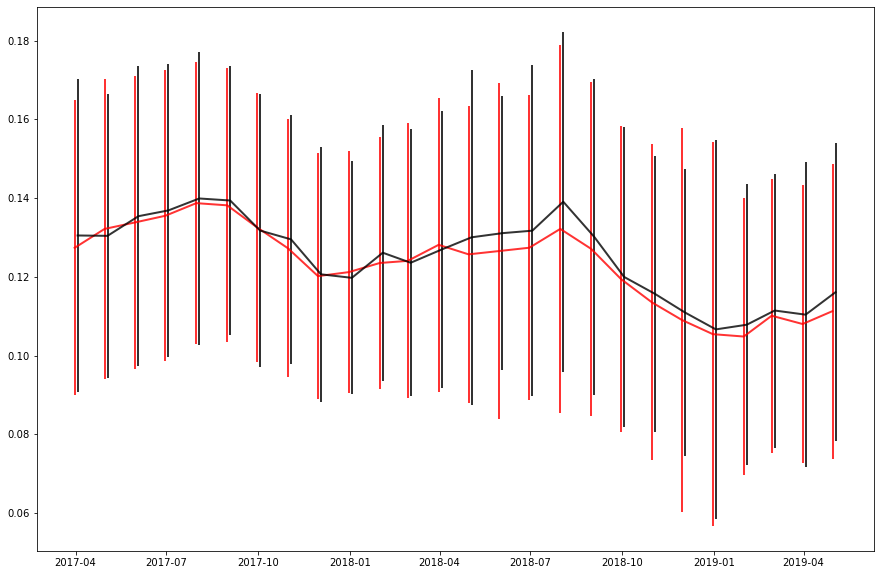

In [13]:
import matplotlib.pyplot as plt
import datetime as dt

# merge MONTHLY data with practice allocations 
plot_data = df1.loc[(df1.month_no>-14) & (df1.month_no<22)]
    
    
def plot_timetrends(df=plot_data, ymin=0.05, ymax=0.19, legend_loc="lower left", ylabel="proportion broad spectrum"): 
    # remove rows where measure value is null
    dfp = df.loc[~(pd.isnull(df.calc_value))].copy()
    dfp = prac.merge(dfp, how='left', on='practice_id')
    dfp = dfp[['practice_id','month','allocation','group_ab','calc_value']]
    
    fig = plt.subplots(figsize=(15,10))

    dfp2 = dfp.loc[dfp["month"]>"2017-03-01"].groupby(['month','allocation']).mean().unstack()
    dfp2.columns = dfp2.columns.droplevel()
    dfp2.reset_index(inplace=True)

    yerror = dfp.loc[dfp["month"]>"2017-03-01"].groupby(['month','allocation']).std().unstack()
    yerror.columns = yerror.columns.droplevel()
    yerror.reset_index(inplace=True)

    plt.errorbar(dfp2["month"] + pd.Timedelta(days=-1), dfp2["I"], color='r',alpha=0.8, linewidth=2, yerr=yerror["I"],label="Intervention +/-SD")
    plt.errorbar(dfp2["month"] + pd.Timedelta(days=2), dfp2["con"], color='k', alpha=0.8, linewidth=2, yerr=yerror["con"],label="control +/-SD")


    # Add vertical lines for significant time points
    xposition = ['2017-09-01', '2018-02-01','2018-09-01','2019-02-01','2018-05-01','2018-07-01']
    plt.axvspan(dt.datetime(xposition[0]), xposition[1], facecolor='g', alpha=0.1, label="baseline")
    plt.axvspan(xposition[4], xposition[5], facecolor='k', alpha=0.1, label="intervention period")
    plt.axvspan(xposition[2], xposition[3], facecolor='m', alpha=0.1, label="follow-up")


    plt.legend(loc=legend_loc, fontsize=15)

    plt.ylabel(ylabel, fontsize=20)
    plt.xticks(rotation=90, size=14)
    plt.yticks(size=12)

    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,ymin, ymax))

    plt.show()

    
plot_timetrends()

ConversionError: Failed to convert value(s) to axis units: ['2017-09-01', '2018-02-01']

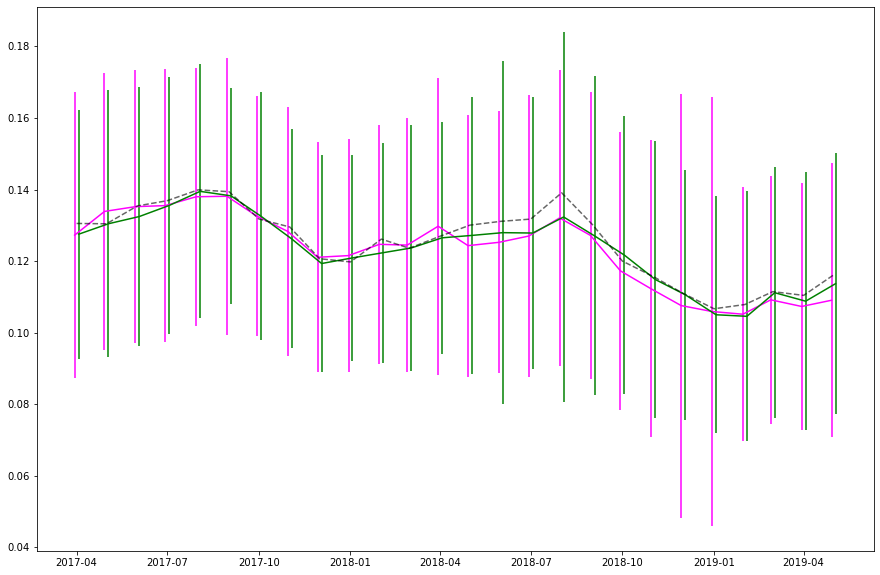

In [8]:
fig = plt.subplots(figsize=(15,10))

dfp = df1.loc[(df1.month_no>-14) & (df1.month_no<22)]
dfp = dfp.loc[~(pd.isnull(dfp.calc_value))]
dfp = prac.merge(dfp, how='left', on='practice_id')
dfp = dfp[['practice_id','month','allocation','group_ab','calc_value']]

dfp3 = dfp.loc[dfp["month"]>"2017-03-01"].groupby(['month','group_ab']).mean().unstack()
dfp3.columns = dfp3.columns.droplevel()
dfp3.reset_index(inplace=True)

yerror = dfp.loc[dfp["month"]>"2017-03-01"].groupby(['month','group_ab']).std().unstack()
yerror.columns = yerror.columns.droplevel()
yerror.reset_index(inplace=True)

plt.errorbar(dfp3["month"] + pd.Timedelta(days=-2), dfp3["A"], yerr=yerror["A"],label="behavioural impact +/-SD", color="magenta")
plt.errorbar(dfp3["month"] + pd.Timedelta(days=2), dfp3["B"], yerr=yerror["B"],label="plain +/-SD", color="g")
plt.errorbar(dfp3["month"], dfp3["con"],label="control", linestyle="--", alpha=0.6, color="k")

# Add vertical lines for significant time points
xposition = ['2017-09-01', '2018-02-01','2018-09-01','2019-02-01','2018-05-01','2018-07-01']
plt.axvspan(xposition[0], xposition[1], facecolor='g', alpha=0.1, label="baseline")
plt.axvspan(xposition[4], xposition[5], facecolor='k', alpha=0.1, label="intervention period")
plt.axvspan(xposition[2], xposition[3], facecolor='m', alpha=0.1, label="follow-up")


plt.legend(loc='lower left', fontsize=15)

plt.ylabel("proportion broad spectrum", fontsize=20)
plt.xticks(rotation=90, size=14)
plt.yticks(size=14)

plt.show()

# Primary Outcome

In [ ]:
# exclude practices with no follow-up data
data = dfx2.loc[pd.notnull(dfx2["Follow-up Measure"])].copy().reset_index()
# create a new Series called "intervention" to convert intervention/control to numerichange["Percentage Change"] = change['Change in Items']/change['Follow-up Items']cal values
data['intervention'] = data.allocation.map({'con':0, 'I':1})

summary = data.groupby("intervention")[["Baseline Items", "Baseline Measure", "Follow-up Measure"]].mean() 
summary["change"] = summary["Follow-up Measure"] - summary["Baseline Measure"]
#calculate difference in changes
summary = summary.append(summary.iloc[1]-summary.iloc[0], ignore_index=True)

100*summary.round(4)

In [ ]:

# Difference in the proportion of antibiotics prescribed which were broad-spectrum, 
#between intervention and control groups, assessed by applying a multivariable linear regression model.

import statsmodels.formula.api as smf

# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.allocation.map({'con':0, 'I':1})

formula = 'data["Follow-up Measure"] ~ data["Baseline Measure"] + intervention'

lm = smf.ols(formula=formula, data=data).fit()
lm.summary()


## Primary outcome: Compare subgroups of intervention group

In [ ]:
# include intervention group only & where follow-up data exists
data2 = dfx2.copy().loc[(dfx2.allocation=="I") & (pd.notnull(dfx2["Follow-up Measure"]))].reset_index() 
 
# create a new Series called groupb to convert A/B allocation to numeric
data2['groupb'] = data2.group_ab.map({'A':0, 'B':1})

summary = data2.groupby("groupb")[["Baseline Measure", "Follow-up Measure"]].mean() 
summary["change"] = summary["Follow-up Measure"] - summary["Baseline Measure"]
#calculate difference in changes
summary = summary.append(summary.iloc[1]-summary.iloc[0], ignore_index=True)

100*summary.round(4)

In [ ]:
### Regression for group A vs B

formula2 = 'data2["Follow-up Measure"] ~ data2["Baseline Measure"]  + groupb'

lm = smf.ols(formula=formula2, data=data2).fit()

lm.summary()

# Secondary Outcome

### Estimated overall effect of the intervention on the number of broad-spectrum antibiotics prescribed during the follow-up period. 
This will be calculated as the total difference between the observed number of broad-spectrum antibiotics per practice and the expected number had they been in the control group ~~using the regression model~~ 

In [ ]:
change = data.groupby(['allocation']).agg({'practice_id':'count',       
                                 'Baseline Items': 'sum',
                                 'Baseline Denominator': 'sum',
                                 'Follow-up Items': 'sum',
                                 'Follow-up Denominator': 'sum'})

# Calculate overall proportion from total items across all practices
change["Baseline Measure"] = change['Baseline Items'] / change['Baseline Denominator']
change["Follow-up Measure"] = change['Follow-up Items'] / change['Follow-up Denominator']

# Calculate change in overall proportion and model change for both groups
# if all were in control group
change["Measure change"] = change["Follow-up Measure"] - change["Baseline Measure"]
change["Measure change model"] = change.loc["con","Measure change"]
change["Predicted measure"] = change["Baseline Measure"] + change["Measure change model"]
change["Predicted Items"] = change["Follow-up Denominator"]*change["Predicted measure"]

change["Change in Items"] = change["Follow-up Items"] - change["Predicted Items"]
change["% Change in Items"] = 100*change["Change in Items"] / change["Follow-up Items"]

change


### Repeat for Behavioural impact vs plain feedback groups
(Estimated overall effect of the intervention on the number of broad-spectrum antibiotics prescribed during the follow-up period)

In [ ]:
change = data2.groupby(['group_ab']).agg({'practice_id':'count',       
                                 'Baseline Items': 'sum',
                                 'Baseline Denominator': 'sum',
                                 'Follow-up Items': 'sum',
                                 'Follow-up Denominator': 'sum'})

# Calculate overall proportion from total items across all practices
change["Baseline Measure"] = change['Baseline Items'] / change['Baseline Denominator']
change["Follow-up Measure"] = change['Follow-up Items'] / change['Follow-up Denominator']

# Calculate change in overall proportion and model change for both groups
# if all were in least effective group 
change["Measure change"] = change["Follow-up Measure"] - change["Baseline Measure"]
change["Measure change model"] = change["Measure change"].max()
change["Predicted measure"] = change["Baseline Measure"] + change["Measure change model"]
change["Predicted Items"] = change["Follow-up Denominator"]*change["Predicted measure"]

change["Change in Items"] = change["Follow-up Items"] - change["Predicted Items"]
change["% Change in Items"] = 100*change["Change in Items"] / change["Follow-up Items"]


change

## Other antibiotic prescribing measures
### Total antibiotics per STAR-PU

In [ ]:
q = '''SELECT *, DATE_DIFF(month,'2017-08-01', MONTH) AS month_no FROM ebmdatalab.measures.practice_data_ktt9_antibiotics
WHERE EXTRACT (YEAR from month)  >= 2017
'''
dftotal = bq.cached_read(q, csv_path='data/total_antibiotics_data.csv')
dftotal["month"] = pd.to_datetime(dftotal.month)
dftotal.info()

In [ ]:
import matplotlib.pyplot as plt

# merge MONTHLY data with practice allocations 
dfp = dftotal.loc[(dftotal.month_no>-14) & (dftotal.month_no<22)]
# remove rows where measure value is null, or denominator (practice population) very small
dfp = dfp.loc[~(pd.isnull(dfp.calc_value))&(dfp.denominator>100)]

plot_timetrends(df=dfp, ymin=0, ymax=0.15, ylabel="total antibiotics per STAR-PU")

In [ ]:
### select data only for the baseline and follow-up periods
import datetime
dft2 = dftotal.copy()
conditions = [
    (dft2['month']  >= d4), # after follow-up period
    (dft2['month']  >= d3), # follow-up
    (dft2['month']  >= d2), # mid
    (dft2['month']  >= d1), # baseline
    (dft2['month']  < d1)] # before

choices = ['after', 'follow-up', 'mid', 'baseline','before']
dft2['period'] = np.select(conditions, choices, default='0')

# take columns of interest from df
dft2 = dft2[["practice_id","period", "month", "numerator","denominator"]]
dft2 = dft2.set_index(["practice_id","period", "month"])
dft2.head(5)

In [ ]:

dftm = dft2.reset_index()
dftm = dftm.loc[(dftm.period=="baseline") | (dftm.period=="follow-up")]

### sum numerator and average the denominators for each practice for each period
dftm = dftm.groupby(["practice_id","period"]).agg({"numerator":"sum","denominator":"mean"})

### calculate aggregated measure values
dftm["calc_value"] = dftm.numerator / dftm.denominator

# unstack years
dftm = dftm.reset_index()
dftm = dftm[["practice_id","period","calc_value","numerator","denominator"]].set_index(["practice_id","period"]) 
dftm = dftm.unstack(1)

# rename columns appropriately
dftm.columns = dftm.columns.droplevel()
dftm.columns.values[0] = 'Baseline Measure'
dftm.columns.values[1] = 'Follow-up Measure'
dftm.columns.values[2] = 'Baseline Items'
dftm.columns.values[3] = 'Follow-up Items'
dftm.columns.values[4] = 'Baseline Denominator'
dftm.columns.values[5] = 'Follow-up Denominator'

dftm = prac.merge(dftm, how='left', on='practice_id')
dftm.head()

In [ ]:
import statsmodels.formula.api as smf
data = dftm.copy()

# remove infinite values
data["Follow-up Measure"] = data["Follow-up Measure"].replace([np.inf, -np.inf], np.nan)
# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.allocation.map({'con':0, 'I':1})

lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"] + intervention', data=data).fit()

lm.summary()

In [ ]:
import statsmodels.formula.api as smf
data = dftm.loc[dftm.allocation=="I"]

# remove infinite values
data["Follow-up Measure"] = data["Follow-up Measure"].replace([np.inf, -np.inf], np.nan)
# create a new Series called "intervention" to convert intervention/control to numerical values
data['groupb'] = data.group_ab.map({'A':0, 'B':1})

lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"] + groupb', data=data).fit()

lm.summary()

### UTI antibiotics (ADQs)

In [ ]:
q = '''SELECT *, DATE_DIFF(month,'2017-08-01', MONTH) AS month_no FROM ebmdatalab.measures.practice_data_ktt9_uti_antibiotics
WHERE EXTRACT (YEAR from month)  >= 2017
'''
dfuti = bq.cached_read(q, csv_path='data/uti_antibiotics_data.csv')
dfuti["month"] = pd.to_datetime(dfuti.month)
dfuti.info()

In [ ]:
import matplotlib.pyplot as plt


# merge MONTHLY data with practice allocations 
dfuti2 = dfuti.loc[(dfuti.month_no>-14) & (dfuti.month_no<22)]


plot_timetrends(df=dfuti2,ymin=2,ymax=9,legend_loc="lower left",ylabel="mean number of ADQs per item")

**Statistical test**

In [ ]:
### select data only for the baseline and follow-up periods
import datetime
dfutim = dfuti.copy()
conditions = [
    (dfutim['month']  >= d4), # after follow-up period
    (dfutim['month']  >= d3), # follow-up
    (dfutim['month']  >= d2), # mid
    (dfutim['month']  >= d1), # baseline
    (dfutim['month']  < d1)] # before

choices = ['after', 'follow-up', 'mid', 'baseline','before']
dfutim['period'] = np.select(conditions, choices, default='0')

# take columns of interest from df
dfutim = dfutim[["practice_id","period", "month", "numerator","denominator"]]
dfutim = dfutim.set_index(["practice_id","period", "month"])

dfutim = dfutim.reset_index()
dfutim = dfutim.loc[(dfutim.period=="baseline") | (dfutim.period=="follow-up")]

### sum numerator and average the denominators for each practice for each period
dfutim = dfutim.groupby(["practice_id","period"]).agg({"numerator":"sum","denominator":"mean"})

### calculate aggregated measure values
dfutim["calc_value"] = dfutim.numerator / dfutim.denominator

# unstack years
dfutim = dfutim.reset_index()
dfutim = dfutim[["practice_id","period","calc_value","numerator","denominator"]].set_index(["practice_id","period"]) 
dfutim = dfutim.unstack(1)

# rename columns appropriately
dfutim.columns = dfutim.columns.droplevel()
dfutim.columns.values[0] = 'Baseline Measure'
dfutim.columns.values[1] = 'Follow-up Measure'
dfutim.columns.values[2] = 'Baseline Items'
dfutim.columns.values[3] = 'Follow-up Items'
dfutim.columns.values[4] = 'Baseline Denominator'
dfutim.columns.values[5] = 'Follow-up Denominator'

dfutim = prac.merge(dfutim, how='left', on='practice_id')


import statsmodels.formula.api as smf
data = dfutim.copy()
# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.allocation.map({'con':0, 'I':1})

lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"] + intervention', data=data).fit()

lm.summary()

In [ ]:
import statsmodels.formula.api as smf
data = dfutim.loc[dfutim.allocation=="I"]

# remove infinite values
data["Follow-up Measure"] = data["Follow-up Measure"].replace([np.inf, -np.inf], np.nan)
# create a new Series called "intervention" to convert intervention/control to numerical values
data['groupb'] = data.group_ab.map({'A':0, 'B':1})

lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"] + groupb', data=data).fit()

lm.summary()

**Trimethoprim**

In [ ]:
q = '''SELECT *, DATE_DIFF(month,'2017-08-01', MONTH) AS month_no FROM ebmdatalab.measures.practice_data_trimethoprim
WHERE EXTRACT (YEAR from month)  >= 2017
'''
dftrim = bq.cached_read(q, csv_path='data/antibiotics_nitrofurantoin_data.csv')
dftrim["month"] = pd.to_datetime(dftrim.month)
dftrim.info()

In [ ]:
import matplotlib.pyplot as plt

# merge MONTHLY data with practice allocations 
trim = dftrim.loc[(dftrim.month_no>-14) & (dftrim.month_no<22)]
plot_timetrends(df=trim,ymax=0.8,
                ylabel="trimethoprim % of all nitrofurantoin and trimethoprim items")

In [ ]:
### select data only for the baseline and follow-up periods
import datetime
dftrimm = dftrim.copy()
conditions = [
    (dftrimm['month']  >= d4), # after follow-up period
    (dftrimm['month']  >= d3), # follow-up
    (dftrimm['month']  >= d2), # mid
    (dftrimm['month']  >= d1), # baseline
    (dftrimm['month']  < d1)] # before

choices = ['after', 'follow-up', 'mid', 'baseline','before']
dftrimm['period'] = np.select(conditions, choices, default='0')

# take columns of interest from df
dftrimm = dftrimm[["practice_id","period", "month", "numerator","denominator"]]
dftrimm = dftrimm.set_index(["practice_id","period", "month"])

dftrimm = dftrimm.reset_index()
dftrimm = dftrimm.loc[(dftrimm.period=="baseline") | (dftrimm.period=="follow-up")]

### sum numerator and average the denominators for each practice for each period
dftrimm = dftrimm.groupby(["practice_id","period"]).agg({"numerator":"sum","denominator":"mean"})

### calculate aggregated measure values
dftrimm["calc_value"] = dftrimm.numerator / dftrimm.denominator

# unstack years
dftrimm = dftrimm.reset_index()
dftrimm = dftrimm[["practice_id","period","calc_value","numerator","denominator"]].set_index(["practice_id","period"]) 
dftrimm = dftrimm.unstack(1)

# rename columns appropriately
dftrimm.columns = dftrimm.columns.droplevel()
dftrimm.columns.values[0] = 'Baseline Measure'
dftrimm.columns.values[1] = 'Follow-up Measure'
dftrimm.columns.values[2] = 'Baseline Items'
dftrimm.columns.values[3] = 'Follow-up Items'
dftrimm.columns.values[4] = 'Baseline Denominator'
dftrimm.columns.values[5] = 'Follow-up Denominator'

dftrimm = prac.merge(dftrimm, how='left', on='practice_id')


import statsmodels.formula.api as smf
data = dftrimm.copy()
# create a new Series called "intervention" to convert intervention/control to numerical values
data['intervention'] = data.allocation.map({'con':0, 'I':1})

lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"] + intervention', data=data).fit()

lm.summary()

In [ ]:
import statsmodels.formula.api as smf
data = dftrimm.loc[dftrimm.allocation=="I"]

# remove infinite values
data["Follow-up Measure"] = data["Follow-up Measure"].replace([np.inf, -np.inf], np.nan)
# create a new Series called "intervention" to convert intervention/control to numerical values
data['groupb'] = data.group_ab.map({'A':0, 'B':1})

lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"] + groupb', data=data).fit()

lm.summary()

## Subgroup analyses

### SA1. Regression for Intervention vs Control - analyse effect of LIST SIZE

In [ ]:
import statsmodels.formula.api as smf

data = dfx2.copy()
data['intervention'] = data.allocation.map({'con':0, 'I':1})

# find average list size of each practice, during the intervention period
q = '''SELECT practice, 
avg(total_list_size) AS list_size 
FROM ebmdatalab.hscic.practice_statistics
WHERE month BETWEEN "2018-05-01" AND "2018-07-01"
GROUP BY practice
'''
listsize = bq.cached_read(q, csv_path='data/list_size_covariate_data.csv')


data = data.merge(listsize, left_on="practice_id", right_on="practice", how="inner")

# convert list size to deciles
data["list_size_decile"] = 100*(data["list_size"].rank(pct=True)).round(1) 


lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"] + list_size_decile + intervention', data=data).fit()

lm.summary()

### SA2. Regression for subgroup of intervention group INTERACTING with any intervention

**Obtain data**

In [ ]:
campaign2 = pd.read_csv('data/pageviews_wave123.csv',usecols={"Page","Pageviews","Medium","Segment","Unique Pageviews","Avg. Time on Page","Bounce Rate"})

c = campaign2.copy()
c = c.loc[c['Page'].str.find('practice') !=-1]
# extract practice, wave and medium information:
n0 = c['Page'].str.find('practice')+len("practice/")
n1 = c['Medium'].str.find(' ')
c["n0"] = n0
n2 = c['Segment'].str.len()

# trim medium to reduce the options to 'post 'email' and 'fax'
c["medium"] = c.Medium.str[0:1]


c[['x','practice_id']] = c['Page'].str.split("practice/",expand=True)
c['practice_id'] = c['practice_id'].str[0:6]
#c["n0"]
c["wave"] = c["Segment"].str[-1].astype(int)

c = c[c['practice_id'] != ""].drop(["Medium","Segment","x","n0"], axis=1)

c.sort_values(by="Unique Pageviews").reset_index(drop=True).head(10)

### NB some lines appear with no data due to the way the report is produced in Analytics

c = c.loc[c["Pageviews"]>0]
browsing = c.copy() # for exploratory analysis later

# group by practice and find max page views (will convert to boolian in next cell)
c = c.groupby(["practice_id"])["Pageviews"].max().reset_index()
c.head()

**Summary**

In [ ]:
data = dfx2.loc[dfx2.allocation=="I"]

####### find interacting vs not interacting ######################
data = data.merge(c, on="practice_id", how="left")
data['interaction'] = np.where(data["Pageviews"]>0, 1, 0)

summary = data.groupby("interaction").agg({"practice_id":"count","Baseline Measure":"mean", "Follow-up Measure":"mean"}) 
summary["change"] = summary["Follow-up Measure"] - summary["Baseline Measure"]
#calculate difference in changes
summary = summary.append(summary.iloc[1]-summary.iloc[0], ignore_index=True)

summary.round(4)

**Analysis**

In [ ]:
##The primary prescribing outcome measure will also be compared between the sub-groups 
# interacting with the link supplied, versus those not interacting; 

import statsmodels.formula.api as smf

lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"]  + interaction', data=data).fit()

lm.summary()

### SA3. Regression for subgroup of intervention group OPTING OUT


In [ ]:

# ...and for the sub-group which excludes those opting-out of the intervention.

# Identify which practices were successfully contacted: 
# load csv containing information which means of contact were sent to each practice and which were undelivered
# NB all null for letters.

cont = pd.read_csv('data/intervention_report_v2.csv',usecols={"practice_id","wave","method","sent","delivery_success"}).fillna(0)
cont = cont.rename(columns={"method":"medium"})

c2 = cont.groupby(["practice_id","wave"])[["sent"]].sum().reset_index()
c2 = pd.pivot(c2, index="practice_id", columns="wave", values="sent").reset_index()
c2["flag"] = np.where(c2[3]<=1, 1, 0)
c2[c2["flag"]>0]


data = dfx2.loc[dfx2.allocation=="I"] # include intervention group only
data = data.merge(c2[["practice_id","flag"]], on="practice_id", how="left")


####### find opting out vs not opting out ######################
import statsmodels.formula.api as smf
data['opt_out'] = data["flag"]


lm = smf.ols(formula='data["Follow-up Measure"] ~ data["Baseline Measure"]  + opt_out', data=data).fit()

lm.summary()